In [21]:
%matplotlib inline
import pandas as pd
from meta import ga
from BIKNN import BIKNN
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# BIKNN on Small Dataset

In [3]:
final_ratings = pd.read_csv('data/final_rating.csv')
final_ratings.head()

,userID,placeID,rating
0,1,32,2
1,1,33,1
2,1,76,2
3,1,82,1
4,1,86,1


In [7]:
# X_train and X_test is your training and testing data
X_train, X_test = train_test_split( 
    final_ratings, 
    test_size = 0.2, 
    stratify = final_ratings['userID'].values,
    random_state = 1234 # this is the seed for reproducible train/test split
)
X_train.head()

,userID,placeID,rating
901,109,79,2
72,8,41,1
728,90,107,2
327,39,16,1
131,15,49,1


In [8]:
# this runs a single BIKNN
biknn_model = BIKNN( K = 20, B1 = 25, B2 = 25 )
biknn_model.fit( data = X_train, columns = [ 'user_id', 'item_id', 'ratings' ] )
mae = biknn_model.update( X_test, iterations = 1000 )
print(mae)

0.581195183863


In [22]:
# genetic algorithm BIKNN
ga1 = ga( 
    pop_size = 15, 
    chromo_len = 2, 
    lower_bound = 0, 
    upper_bound = 100,
    retain = 0.5, 
    mutate = 0.2, 
    generation = 5,
    K = 20,
    data = X_train,
    columns = [ 'user_id', 'item_id', 'ratings' ],
    test = X_test,
    iterations = 1000
)
print(ga1)

iteration 1's best generation: generation_info(cost=0.53970114529945057, chromo=[40, 6])
iteration 2's best generation: generation_info(cost=0.5384025073136548, chromo=[91, 6])
iteration 3's best generation: generation_info(cost=0.5384025073136548, chromo=[91, 6])
iteration 4's best generation: generation_info(cost=0.5384025073136548, chromo=[91, 6])
iteration 5's best generation: generation_info(cost=0.52723344693409568, chromo=[91, 4])
[generation_info(cost=0.53970114529945057, chromo=[40, 6]), generation_info(cost=0.5384025073136548, chromo=[91, 6]), generation_info(cost=0.5384025073136548, chromo=[91, 6]), generation_info(cost=0.5384025073136548, chromo=[91, 6]), generation_info(cost=0.52723344693409568, chromo=[91, 4])]


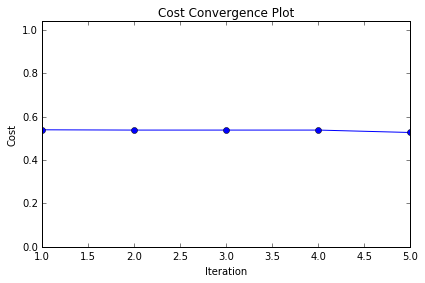

In [33]:
costs = [ ga.cost for ga in ga1 ]
plt.plot( range( 1, len(ga1) + 1 ), costs, '-o' )
plt.title( 'Cost Convergence Plot' )
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.ylim( 0, costs[0] + 0.5 )
plt.tight_layout()
plt.show()

# BIKNN on Big Dataset

In [44]:
# the full dataset
# column order: user id, item id and ratings
train = pd.read_csv( 'data/u1.base', sep = '\t', header = None )
train = train.iloc[ :, 0:3 ]
test  = pd.read_csv( 'data/u1.test', sep = '\t', header = None )
test  = train.iloc[ :, 0:3 ]
column_names = [ 'user_id', 'item_id', 'ratings' ]
train.columns = column_names
test.columns  = column_names
train.head()
print(train.shape)

(80000, 3)


In [45]:
# only retain users that are frequently rating 
# change the quantile for percentage that are retained
histogram_counts = train['user_id'].value_counts()
df_value_counts = pd.DataFrame( histogram_counts > histogram_counts.quantile(0.5) )
df_value_counts.reset_index( inplace = True )
frequent_users = df_value_counts.loc[ df_value_counts['user_id'] == True, 'index' ]

train = train[ train['user_id'].isin(frequent_users) ]
test  = test[  test['user_id'].isin(frequent_users) ]
print(train.shape)
print(test.shape)

(66810, 3)
(66810, 3)


In [46]:
"""
data = pd.read_csv( 'test_data.txt', sep = ',', header = None )
data.head(4)
dict1 = { 
    'user_id': [6, 5],
    'item_id': [1, 2],
    'ratings': [5, 2]
}
test1 = pd.DataFrame( dict1, columns = [ 'user_id', 'item_id', 'ratings' ] )
test1
"""
print('ignore this code chunk')

ignore this code chunk
